In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Pair Trading of OIH/XLE Pair

### Getting the Data
We load the data and plot the two price series. We do a scatterplot of the two series against each other, with each point coloured by the date.

In [3]:
OIH_data = pd.read_csv("OIH.csv")
XLE_data = pd.read_csv("XLE.csv")

In [4]:
df = XLE_data[["Date", "Adj Close"]].rename(columns={"Adj Close": "XLE"})
df["Date"] = pd.to_datetime(df["Date"])
df["OIH"] = OIH_data["Adj Close"]

In [5]:
df = df[df["Date"] < pd.Timestamp("2017-01-01")]
df = df[df["Date"] > pd.Timestamp("2010-01-01")].reset_index(drop=True)

array([<Axes: >, <Axes: >], dtype=object)

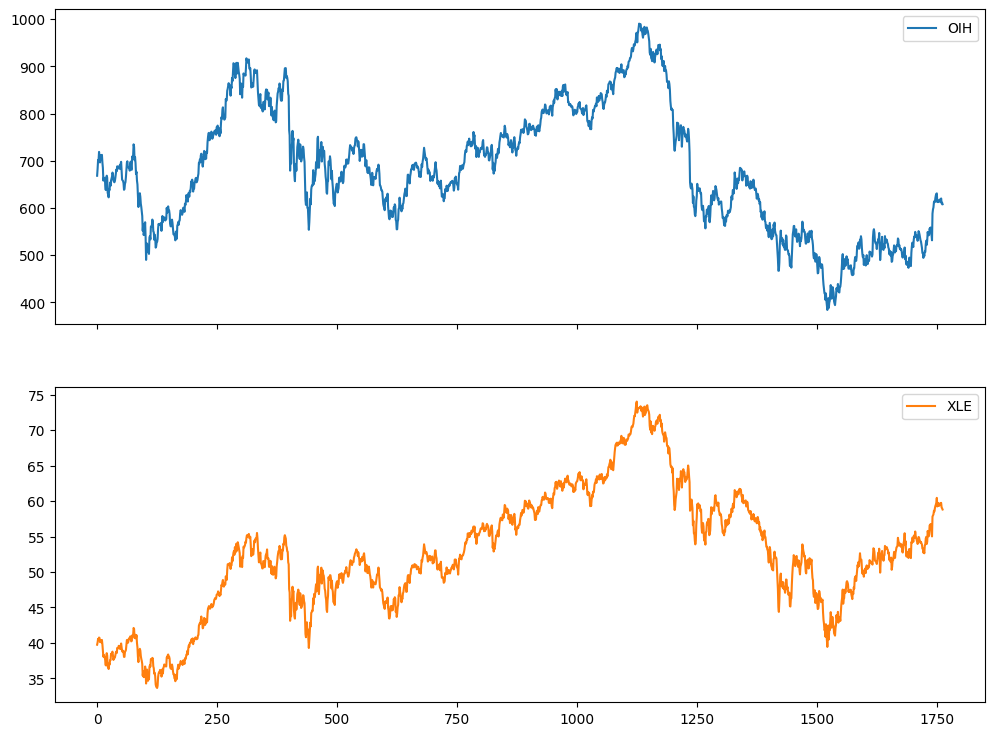

In [6]:
df[["OIH", "XLE"]].plot(subplots=True, figsize=(12,9))

In [7]:
# Boilerplate to generate a few arrays that are queried later
XLE_price = df["XLE"].to_numpy()
OIH_price = df["OIH"].to_numpy()

<Axes: xlabel='XLE', ylabel='OIH'>

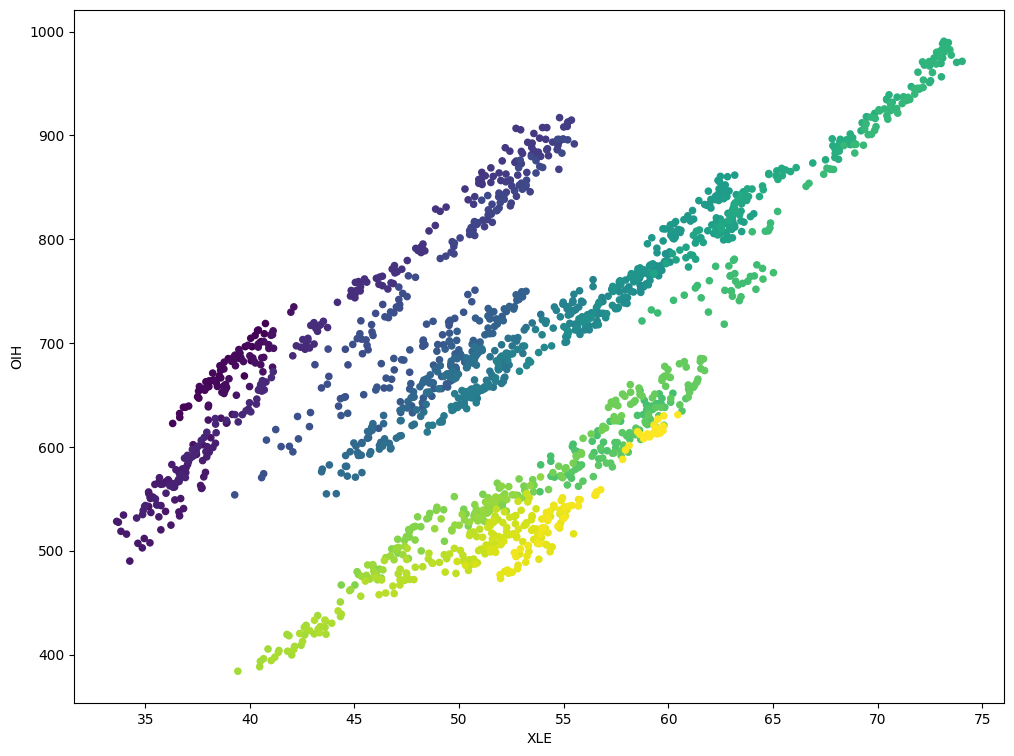

In [8]:
df.plot.scatter(x="XLE", y="OIH", c="Date", figsize=(12,9))

## Linear Model Solution for Hedge Ratio

We want to capture the dynamics of the spread linearly in time, directly from the prices. Code a rolling linear model that captures the in-fit residual, extract the coefficient and plot it. Denote your column `rolling_hedge_ratio`. What kind of lookback length should be used? As an alternative, we could consider log prices and the corresponding logarithmic spread. What could be pros and cons of choosing to work in log-price space? Nonetheless, we will remain in price space for the remainder of the exercise.

After that, calculate the `rolling_spread` and visualize it, which is easily done using the Pandas DataFrame method `rolling`. Does it look mean reverting? What issues could we have from trading on it?


In [72]:
from sklearn.linear_model import LinearRegression

window_size = 10
rolling_hedge_ratio = []
rolling_spread = []

# loop through the data frame using a rolling window approach
for i in range(window_size, len(df)):

    # get the window data
    window_data = df.iloc[i - window_size : i + 1]

    # get the returns
    returns_OIH = np.diff(window_data["OIH"])/window_data["OIH"][:-1]
    returns_XLE = np.diff(window_data["XLE"])/window_data["XLE"][:-1]

    # fit a linear regression model
    model = LinearRegression().fit(window_data["OIH"].to_numpy().reshape(-1, 1), window_data["XLE"].to_numpy().reshape(-1, 1))

    # get and store hedge ratio
    hedge_ratio = model.coef_[0][0]
    rolling_hedge_ratio.append(hedge_ratio)

    # get and store spread
    spread = returns_XLE - hedge_ratio * returns_OIH
    rolling_spread.append(spread.to_numpy()[-1]/np.std(spread.to_numpy()))

# append to the dataframe
df["rolling_hedge_ratio"] = [np.nan]*window_size + rolling_hedge_ratio
df["rolling_spread_normalized"] = [np.nan]*window_size + rolling_spread

<Axes: title={'center': 'Rolling hedge ratio'}>

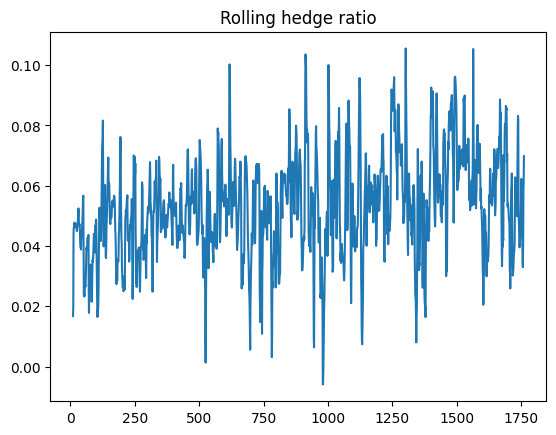

In [73]:
df["rolling_hedge_ratio"].plot(title = "Rolling hedge ratio")

<Axes: title={'center': 'Rolling spread'}>

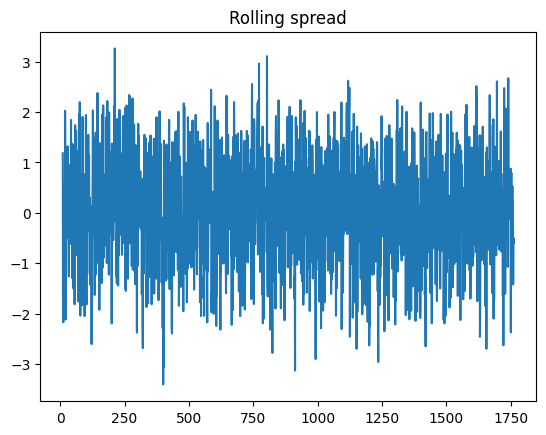

In [74]:
df["rolling_spread_normalized"].plot(title = "Rolling spread")

In [75]:
df.fillna(0, inplace=True)

In the end you, for compability with the below, should have the following columns in your dataframe:
- rolling_spread_normalized: the continuously-normalized spread. 
- rolling_hedge_ratio: the rolling beta of XLE regressed against OIH

In [76]:
df.tail()

,Date,XLE,OIH,rolling_hedge_ratio,rolling_spread,rolling_spread_normalised,rolling_spread_normalized
1757,2016-12-23,59.616875,613.429016,0.032964,0.002263,0.002263,-0.090847
1758,2016-12-27,59.749607,620.174011,0.040974,-0.003037,-0.003037,0.235123
1759,2016-12-28,59.101524,609.600769,0.058208,-0.002680,-0.002680,-1.423236
1760,2016-12-29,58.984386,611.241455,0.060820,-0.003304,-0.003304,-0.497085
1761,2016-12-30,58.812622,607.960144,0.069804,-0.000086,-0.000086,-0.598430


### Strategy Example

- Whenever the spread is above 2, we short the spread
- Whenever the spread is below -2 we go long the spread
- Whenever the spread is at zero we close the position

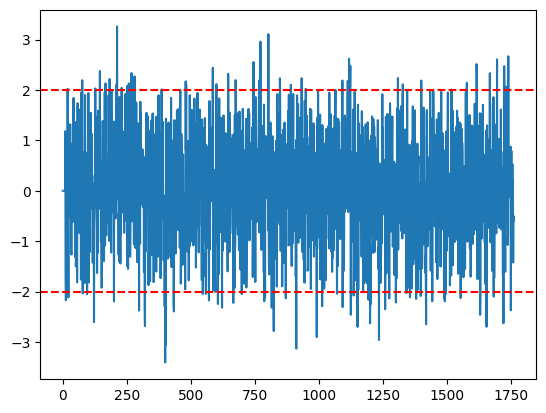

In [77]:
plt.plot(df["rolling_spread_normalized"])
plt.axhline(y=2, color='red', linestyle='--')
plt.axhline(y=-2, color='red', linestyle='--')

### Boilerplate code to run the strategies

In [78]:
def cost_function(p1, p2, p1_prev, p2_prev):
    return 0.0

def test_strategy(hedge_ratio: pd.Series, spread: pd.Series, 
                  lower_bound: float=2., upper_bound: float=2., 
                  long_spread_cutoff:float =0., short_spread_cutoff: float=0.):  
    
    no_days = len(XLE_price)
    
    if isinstance(hedge_ratio, float) or len(hedge_ratio)==1:
        hedge_ratio = np.repeat(hedge_ratio, no_days)
        
    if isinstance(lower_bound, float) or len(lower_bound)==1:
        lower_bound = np.repeat(lower_bound, no_days)
        
    if isinstance(upper_bound, float) or len(upper_bound)==1:
        upper_bound = np.repeat(upper_bound, no_days)
        
    if isinstance(long_spread_cutoff, float) or len(long_spread_cutoff)==1:
        long_spread_cutoff = np.repeat(long_spread_cutoff, no_days)
        
    if isinstance(short_spread_cutoff, float) or len(short_spread_cutoff)==1:
        short_spread_cutoff = np.repeat(short_spread_cutoff, no_days)
    
    if len(spread) == len(hedge_ratio) is False:
        raise Exception("Spread and hedge ratio vectors must be of the same length.")
    
    # Compute Positions
    positions1 = [0]
    positions2 = [0]
    for i in range(len(XLE_price)):
        price1 = XLE_price[i]
        price2 = OIH_price[i]

        p1_next, p2_next = make_decision(price1, price2, positions1[-1], positions2[-1],
                                        hedge_ratio[i], spread[i], lower_bound[i], upper_bound[i],
                                        long_spread_cutoff[i], short_spread_cutoff[i])
        positions1.append(float(p1_next))
        positions2.append(float(p2_next))

    # Compute Returns
    portfolio_multipliers = []
    vals = []
    prev_vals = []
    trading_profit = []
    trading_costs = []
    dollar_pnl = []
    relative_portfolio = []
    absolute_portfolio = []

    for i in range(1, len(XLE_price)):
        p1 = positions1[i]
        p2 = positions2[i]
        
        p1_prev = positions1[i-1]
        p2_prev = positions2[i-1]

        price1 = XLE_price[i]
        price2 = OIH_price[i]
        price1_prev = XLE_price[i-1]
        price2_prev = OIH_price[i-1]

        portfolio_value = p1 * price1 + p2 * price2 # Value prior to your action at t
        portfolio_value_prev = p1 * price1_prev + p2 * price2_prev # Value after your action at t-1
        dollar_return = p1 * (price1-price1_prev) + p2 * (price2-price2_prev)
        costs = cost_function(p1, p2, p1_prev, p2_prev)
        rel_port = p1 * price1 + p2 * price2
        abs_port = np.abs(p1) * price1 + np.abs(p2) * price2
        
        trading_costs.append(costs)
        trading_profit.append(dollar_return)
        relative_portfolio.append(rel_port)
        absolute_portfolio.append(abs_port)
        
        dollar_pnl.append(dollar_return - costs)

    dollar_pnl.append(0)
    trading_costs.append(0)
    trading_profit.append(0)
    relative_portfolio.append(0)
    absolute_portfolio.append(0)

    return pd.DataFrame({"pos1":positions1[1:], "pos2":positions2[1:], "trading_profit": trading_profit, "trading_costs": trading_costs,  "pnl":dollar_pnl, "hedge_ratio":hedge_ratio,
            "spread": spread, "lower_bound": lower_bound, "upper_bound": upper_bound,
            "cumulative_pnl": np.cumsum(dollar_pnl), 
            "relative position": relative_portfolio,
            "absolute_position": absolute_portfolio})


def plot_results(portfolio_df, standard_strategy=False, plot_costs: bool=False):
    portfolio_df_diff = portfolio_df.diff().fillna(0.)
    portfolio_df["date"] = df["Date"]
    portfolio_df_diff["date"] = df["Date"]
    portfolio_df["cumulative_pnl"] = portfolio_df["pnl"].cumsum()
    
    if(plot_costs):
        for x in ["profit", "costs"]:
            portfolio_df[f"cumulative_{x}"] = portfolio_df[f"trading_{x}"].cumsum()
        
    figure = plt.figure(figsize=(12, 12))
    plt.subplot(311)
    plt.title("Spread and positions")
    plt.plot(df["Date"], df["rolling_spread_normalized"])
    plt.plot(df["Date"], portfolio_df["upper_bound"], c="red",  linestyle='--')
    plt.plot(df["Date"], portfolio_df["lower_bound"], c="red",  linestyle='--')
        
    for i in range(portfolio_df_diff.shape[0]):
        if portfolio_df_diff["pos1"][i] != 0:
            plt.axvline(x=portfolio_df_diff.loc[i, "date"], color="green", alpha=0.6)

    plt.grid()

    plt.subplot(312)
    plt.title("Accumulated PNL")
    for i in range(portfolio_df_diff.shape[0]):
        if portfolio_df_diff["pos1"][i] != 0:
            plt.axvline(x=portfolio_df_diff.loc[i, "date"], color="green", alpha=0.6)
    plt.plot(portfolio_df["date"], portfolio_df["cumulative_pnl"])
    if (plot_costs):
        for x in ["profit", "costs"]:
            plt.plot(portfolio_df["date"], portfolio_df[f"cumulative_{x}"])
    plt.grid()

## Build a trading strategy

Below is a function, *make_decision* that takes prices of the two assets and respective positions as input and outputs the desired positions in both assets, in the form of `return pos1, pos2`. The desired positions are normalized to one such that $|p_1| + |p_2| = 1$ or $p_1=p_2=0$ if you have no position at all; the easiest way is to normalize the coefficients of the spread portfolio $(1, \beta)$ by the sum $1+\beta$.

The interpretation of these constraints is that you either invest all of your capital into these two assets or you do not invest anything. For example, if you want to go long in both assets by investing 3 times more of your total capital in asset 1 your output should be 0.75, 0.25. Similarly, if you want to invest equaly but go long asset 1 and short asset 2 your output should be 0.5, -0.5. If you want to close your position your output should be 0, 0.


In [79]:
def make_decision(price1, price2, position1, position2, 
                  hedge_ratio, spread_value, lower=-2., upper=2., 
                  long_spread_cutoff=0., short_spread_cutoff=0.):
    
    # When we go long the spread the output should be (alpha1, alpha2)
    # When we go short the spread the output should be (-alpha1, -alpha2)
    alpha1 = -hedge_ratio / (1 + hedge_ratio)
    alpha2 = 1 / (1 + hedge_ratio)
    
    # Check if there is an open position
    if position2 > 0: # We are long the spread
        if spread_value > long_spread_cutoff: # The price fell below the mean so close the position
            return 0, 0
        else:
            return position1, position2 # Keep the position
    if position2 < 0: # We are short the spread
        if spread_value < short_spread_cutoff:
            return 0, 0 # Close the position
        else:
            return position1, position2 # Keep the position
    if position2 == 0: # We have no position at the moment so see if we want to open a position
        if spread_value < lower:
            return alpha1, alpha2
        if spread_value > upper:
            return -alpha1, -alpha2
    
    return 0, 0

In [80]:
results = test_strategy(hedge_ratio=df["rolling_hedge_ratio"], 
                        spread=df["rolling_spread_normalized"], 
                        lower_bound=-2.5, 
                        upper_bound=2.5, 
                        long_spread_cutoff=0.0, 
                        short_spread_cutoff=-0.0)

In [81]:
results = pd.DataFrame(results)

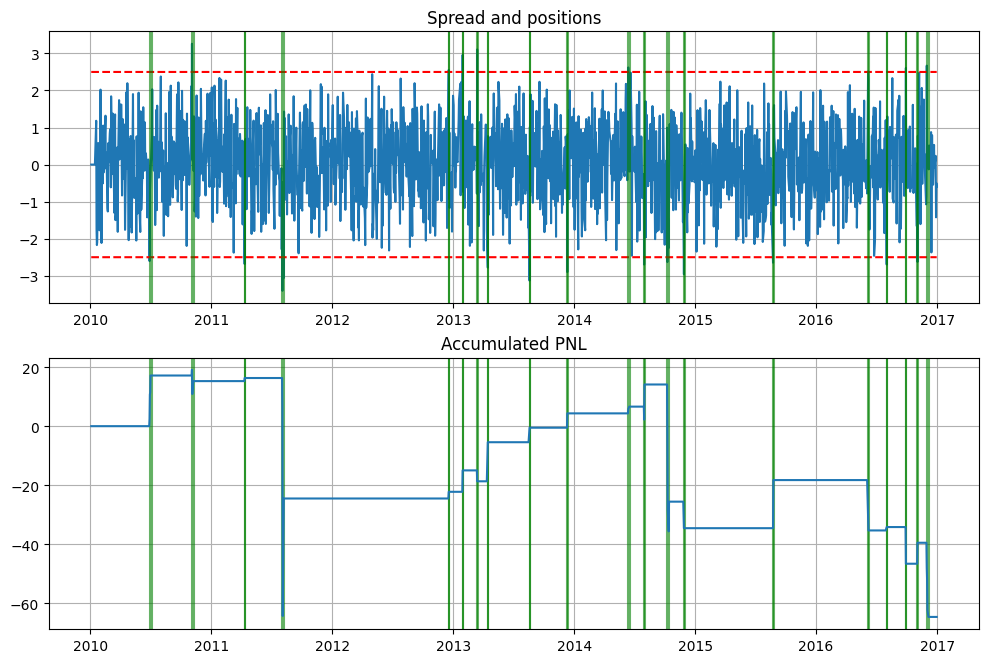

In [82]:
plot_results(results, True)

## Estimating performance

Typically the Sharpe ratio, defined as the Z-score of the daily returns against invested capital against some riskless benchmark,

$$ SR = \frac{\mu_{strat}-r}{\sigma_{strat}},$$

is the first port of call for strategy performance. However, since we are dollar-neutral, we do not have a clear open position at any given time. Can you come up with an alternative way to estimate this for our data? What issues could we run into?

In [90]:
results.tail()

,pos1,pos2,trading_profit,trading_costs,pnl,hedge_ratio,spread,lower_bound,upper_bound,cumulative_pnl,relative position,absolute_position,date
1757,0.0,0.0,0.0,0.0,0.0,0.032964,-0.090847,-2.5,2.5,-64.682262,0.0,0.0,2016-12-23
1758,0.0,0.0,-0.0,0.0,-0.0,0.040974,0.235123,-2.5,2.5,-64.682262,0.0,0.0,2016-12-27
1759,0.0,0.0,0.0,0.0,0.0,0.058208,-1.423236,-2.5,2.5,-64.682262,0.0,0.0,2016-12-28
1760,0.0,0.0,-0.0,0.0,-0.0,0.060820,-0.497085,-2.5,2.5,-64.682262,0.0,0.0,2016-12-29
1761,0.0,0.0,0.0,0.0,0.0,0.069804,-0.598430,-2.5,2.5,-64.682262,0.0,0.0,2016-12-30


In [95]:
risk_free_rate = 0.02
sharpe = (results["cumulative_pnl"].mean() - risk_free_rate)/results["cumulative_pnl"].std()
print(sharpe)

-0.6389589257180843


## Trading Costs

In reality, you can't just take the profits, you have to spend money on trading.

When you execute a trade, you might have to pay money to:

1. Your broker - commissions costs
    - For retail investors, these might just be constant per-trade: e.g. https://www.hl.co.uk/shares/share-dealing/dealing-charges
3. "The market" - the price to buy might be higher than the price to sell (this is called the "spread")
    - In practice, likely to be small for very liquid assets

In [96]:
def cost_function(p1, p2, p1_prev, p2_prev):
    const = 0.00
    lin = 0.01
    t1 = p1 - p1_prev
    t2 = p2 - p2_prev
    c = const if abs(t1) + abs(t2) > 1e-6 else 0.0
    trading_cost = lin * (abs(t1) + abs(t2)) + c
    return trading_cost

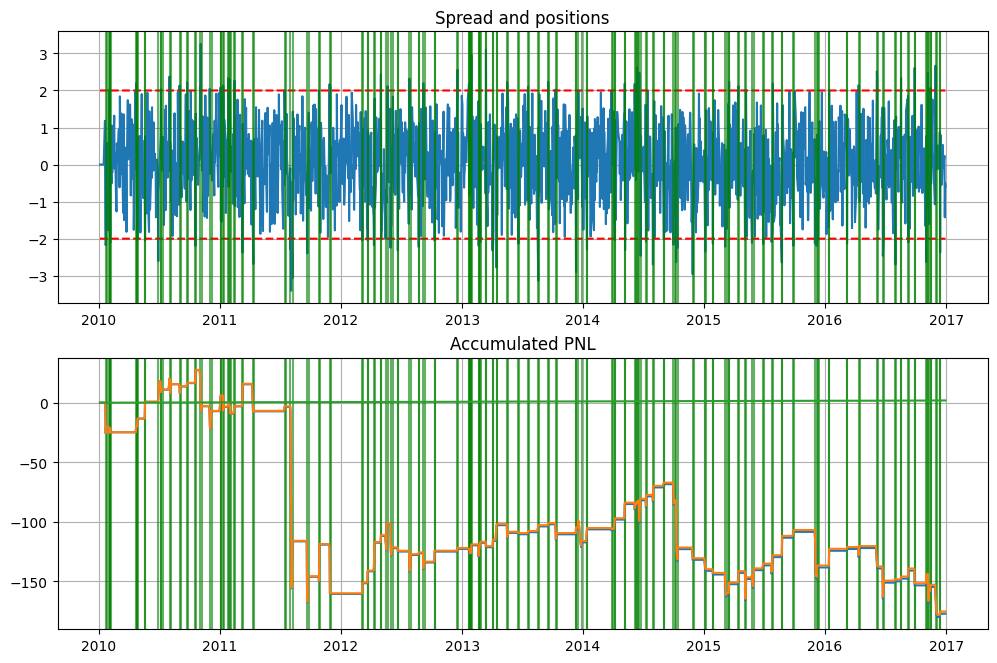

In [97]:
results = test_strategy(df["rolling_hedge_ratio"], df["rolling_spread_normalized"], -2., 2., 0.0, -0.0)
plot_results(results, True,True)

## Holding Costs

There are also costs for holding a position. These could be ETF management fees, as well as the (1) thee cost to borrow money to run (or scale up) the strategy, or (2) to faciliate short positions.

**Discuss what would make a sensible holding cost model, and re-implement cost_function()**

In [11]:
def cost_function(p1, p2, p1_prev, p2_prev):
    return 0.0 # New trading & holding costs model goes here

results = test_strategy(df["rolling_hedge_ratio"], df["rolling_spread_normalized"], -2., 2.0, 0.0, -0.0)
plot_results(results, True,True)

NameError: name 'test_strategy' is not defined

## Market Impact

When you're a retail investor (i.e. a private individual with a RobinHood, HL etc account) your trades won't have any affect on the price.

If you're a large enough market participant, your trades will affect the price of the security.

There are many ways of thinking about this, but we'll assume the following:

- Buying 1 unit of each ETF causes the log(price) to increase by k
- Selling 1 unit of each ETF causes the log(price) to decrease by k

These price changes are persistent and do not decay towards the impact-independent price

In [12]:
def test_strategy_with_impact(hedge_ratio: pd.Series, spread: pd.Series, 
                  lower_bound: float=2., upper_bound: float=2., 
                  long_spread_cutoff:float =0., short_spread_cutoff: float=0.,
                 impact_parameter: float=0.01):  
    
    no_days = len(XLE_price)
    
    if isinstance(hedge_ratio, float) or len(hedge_ratio) ==1:
        hedge_ratio = np.repeat(hedge_ratio, no_days)
        
    if isinstance(lower_bound, float) or len(lower_bound) ==1:
        lower_bound = np.repeat(lower_bound, no_days)
        
    if isinstance(upper_bound, float) or len(upper_bound) ==1:
        upper_bound = np.repeat(upper_bound, no_days)
        
    if isinstance(long_spread_cutoff, float) or len(long_spread_cutoff) ==1:
        long_spread_cutoff = np.repeat(long_spread_cutoff, no_days)
        
    if isinstance(short_spread_cutoff, float) or len(short_spread_cutoff) ==1:
        short_spread_cutoff = np.repeat(short_spread_cutoff, no_days)
    
    if len(spread) == len(hedge_ratio) is False:
        raise Exception("Spread and hedge ratio vectors must be of the same length.")
    
    # Compute Positions
    positions1 = [0]
    positions2 = [0]
    XLE_price_inc_impact = [XLE_price[0]] * len(XLE_price)
    OIH_price_inc_impact = [OIH_price[0]] * len(OIH_price)
    for i in range(len(XLE_price)):
        XLE_price_inc_impact[i] = XLE_price[i] * np.exp(impact_parameter * positions1[i])
        OIH_price_inc_impact[i] = OIH_price[i] * np.exp(impact_parameter * positions2[i])
        price1 = XLE_price_inc_impact[i]
        price2 = OIH_price_inc_impact[i]

        p1_next, p2_next = make_decision(price1, price2, positions1[-1], positions2[-1],
                                        hedge_ratio[i], spread[i], lower_bound[i], upper_bound[i],
                                        long_spread_cutoff[i], short_spread_cutoff[i])
        positions1.append(float(p1_next))
        positions2.append(float(p2_next))

    # Compute Returns
    portfolio_multipliers = []
    vals = []
    prev_vals = []
    trading_profit = []
    trading_costs = []
    dollar_pnl = []

    for i in range(1, len(XLE_price)):
        p1 = positions1[i]
        p2 = positions2[i]
        
        p1_prev = positions1[i-1]
        p2_prev = positions2[i-1]

        rawprice1 = XLE_price_inc_impact[i]
        rawprice2 = OIH_price_inc_impact[i]
        price1_prev = XLE_price[i-1]
        price2_prev = OIH_price[i-1]

        portfolio_value = p1 * price1 + p2 * price2 # Value prior to your action at t
        portfolio_value_prev = p1 * price1_prev + p2 * price2_prev # Value after your action at t-1
        dollar_return = p1 * (price1-price1_prev) + p2 * (price2-price2_prev)
        costs = cost_function(p1, p2, p1_prev, p2_prev)
        
        trading_costs.append(costs)
        trading_profit.append(dollar_return)

        dollar_pnl.append(dollar_return - costs)

    dollar_pnl.append(0)
    trading_costs.append(0)
    trading_profit.append(0)

    return {"pos1":positions1[1:], "pos2":positions2[1:], "trading_profit": trading_profit, "trading_costs": trading_costs,  "pnl":dollar_pnl, "hedge_ratio":hedge_ratio,
           "spread": spread, "lower_bound": lower_bound, "upper_bound": upper_bound, 
            "price_with_impact1": XLE_price_inc_impact, "price_with_impact2": OIH_price_inc_impact}

In [13]:
results = test_strategy_with_impact(df["rolling_hedge_ratio"], df["rolling_spread_normalized"], -2., 2.0, 0.0, -0.0, 0.0)
plot_results(results, True,True)

KeyError: 'rolling_hedge_ratio'